This file runs and produces plots from a simulation. Note that it currently runs clone-level simulations (despite the filename...)

In [1]:
from branching_model import Phylogeny

number_of_treatments = 3
baseline_growth_rate = 0.05
phylogeny = Phylogeny.Phylogeny(
    is_cell=False,
    learning_rate=0.01,
    baseline_growth_rate=baseline_growth_rate,
    resistance_cost=0.4,  # multiplied by sum of resistance scores
    resistance_benefit=2,  # multiplied by treatment effect
    mutations_per_division=0.4,
    number_of_treatments=number_of_treatments,
    seed=1,
    turnover=baseline_growth_rate * 0.1,
)

detection_cell_count = 2000
detection_treatment_delay = 0
# n_timesteps_treatment = 100
measure_tumour_every_n_timesteps = 7
tumour_measurement_delay = 7
phylogeny.run_simulation(
    detection_cell_count,
    detection_treatment_delay,
    measure_tumour_every_n_timesteps,
    tumour_measurement_delay,
    # n_timesteps_treatment,
    max_cycles=10,
)
phylogeny.live_agent_recorder.write_csv("logs/live_agents.csv")

growth rates: 0.01902736723423004 ± 0.0
growth rates: 0.019108185172080995 ± 0.0
growth rates: 0.018913838267326358 ± 0.00027608573436736956
growth rates: 0.01910415291786194 ± 0.00016842186450958217
growth rates: 0.019300398230552674 ± 5.139708518981864e-05
growth rates: 0.0195034995675087 ± 7.524341344833374e-05
growth rates: 0.019715881347656252 ± 0.00021037161350250314
growth rates: 0.0199382558465004 ± 0.0003547057509422305
growth rates: 0.020171430706977845 ± 0.0005090206861495979
growth rates: 0.020416258275508883 ± 0.0006741687655448907
growth rates: 0.02067369818687439 ± 0.000851082801818847
growth rates: 0.02094477564096451 ± 0.0010407879948616042
growth rates: 0.02122747153043747 ± 0.0012412413954734792
growth rates: 0.021521945297718052 ± 0.0014525935053825382
growth rates: 0.02102138623595238 ± 0.0038029633818645334
growth rates: 0.020682814121246337 ± 0.004030327721107193
growth rates: 0.021232735216617588 ± 0.00429396195268074
growth rates: 0.020411189645528793 ± 0.00525

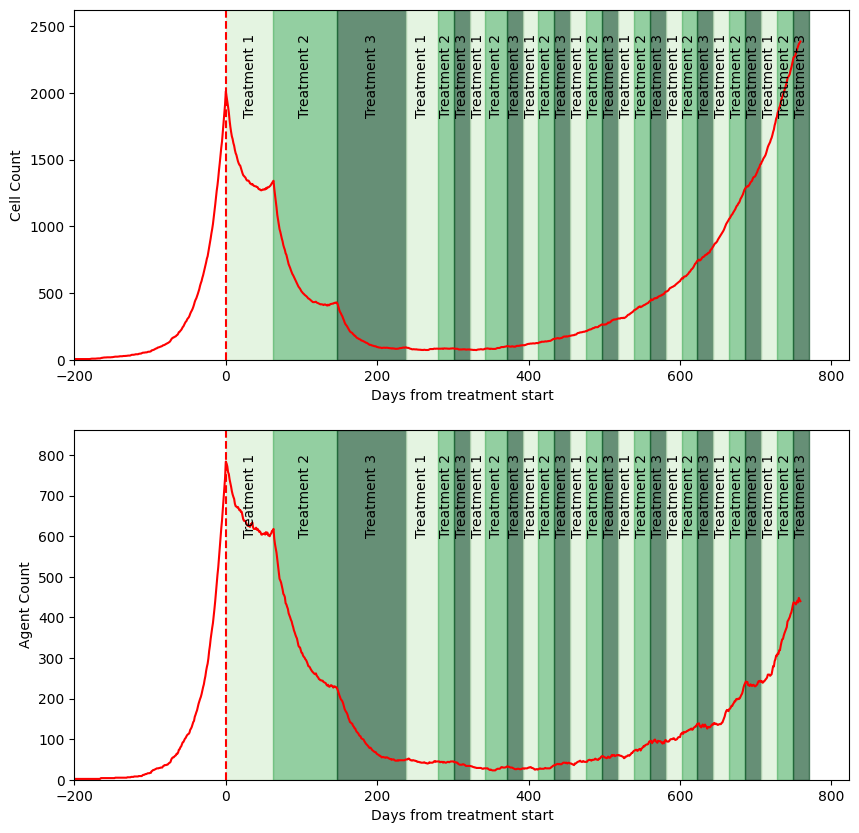

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cell_counts = pd.read_csv("logs/cell_counts.csv").loc[
    lambda df: df["cell_count"] < detection_cell_count * 1.2
]
time_reached_detection = cell_counts[
    cell_counts["cell_count"] >= detection_cell_count
].iloc[0]["timestep"]

cell_counts = cell_counts.assign(
    days_from_detection=lambda df: (
        df["timestep"] - time_reached_detection - detection_treatment_delay
    )
)

cycle_times = pd.read_csv("logs/cycle_times.csv")

max_cell_count = cell_counts["cell_count"].max()
max_agent_count = cell_counts["agent_count"].max()
ylim = {
    "cell_count": (0, max_cell_count + 0.1 * max_cell_count),
    "agent_count": (0, max_agent_count + 0.1 * max_agent_count),
}

# evenly spaced colours from dark green to light green
treatment_colours = plt.cm.Greens(np.linspace(0.2, 1, number_of_treatments))
# plot the cell counts against time
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, column in zip(axes, ["cell_count", "agent_count"]):
    cell_counts.plot(
        x="days_from_detection", y=column, ax=ax, color="red", legend=False
    )
    ax.axvline(x=0, color="red", linestyle="--")  # time_reached_detection,
    # ax.text(
    #     1,
    #     ylim[column][1] * 0.5,
    #     "Tumour detected",
    #     rotation=90,
    #     color="grey",
    # )

    treatment_cycle_lower_x = 0  # time_reached_detection + detection_treatment_delay
    # while (
    #     time_reached_detection
    #     + detection_treatment_delay
    #     + n_timesteps_treatment * treatment_cycle_index
    # ) < len(cell_counts):
    for i, cycle_times_row in cycle_times.iterrows():
        treatment_cycle_upper_x = (
            treatment_cycle_lower_x
            + cycle_times_row["timesteps_to_detection"]
            + tumour_measurement_delay
        )
        if treatment_cycle_lower_x > cell_counts["days_from_detection"].max():
            break
        # treatment = treatment_cycle_index % number_of_treatments
        # treatment_cycle_index += 1
        # ax.axvline(
        #     x=treatment_cycle_lower_x,
        #     color="black",
        #     linestyle="--",
        #     label=f"Switch to treatment {treatment+1}",
        # )
        # ax.text(
        #     treatment_cycle_lower_x + 1,
        #     0,
        #     f"Switch to treatment {treatment+1}",
        #     rotation=90,
        # )
        ax.text(
            (treatment_cycle_lower_x + treatment_cycle_upper_x) / 2,
            ylim[column][1] * 0.7,
            f"Treatment {1 + cycle_times_row['treatment']}",
            ha="center",
            rotation=90,
        )
        ax.fill_betweenx(
            ylim[column],
            treatment_cycle_lower_x,
            treatment_cycle_upper_x,
            alpha=0.6,
            color=treatment_colours[cycle_times_row["treatment"]],
        )
        treatment_cycle_lower_x = treatment_cycle_upper_x
    ax.set_ylim(ylim[column])
    ax.set_xlabel("Days from treatment start")
    ax.set_ylabel(column.replace("_", " ").title())
    ax.set_xlim(-200, ax.get_xlim()[1])
fig.savefig("plots/cell_count.png", dpi=300)

In [3]:
cell_counts

,timestep,cell_count,agent_count,days_from_detection
0,1,1,1,-305
1,2,1,1,-304
2,3,1,1,-303
3,4,1,1,-302
4,5,1,1,-301
...,...,...,...,...
1060,1061,2335,441,755
1061,1062,2352,437,756
1062,1063,2368,448,757
1063,1064,2376,443,758


In [4]:
def get_cycle_start_times(
    cell_counts: pd.DataFrame,
    detection_cell_count: int = 1000,
    tumour_measurement_delay: int = 7,
    detection_treatment_delay: int = 0,
):
    time_reached_detection = cell_counts[
        cell_counts["cell_count"] >= detection_cell_count
    ].iloc[0]["timestep"]
    cycle_start_times = (
        cycle_times["timesteps_to_detection"].cumsum()
        + cycle_times.index * tumour_measurement_delay
        + tumour_measurement_delay
        + time_reached_detection
        + detection_treatment_delay
    )
    return cycle_start_times


# save cycle start times to csv
cycle_start_times = get_cycle_start_times(cell_counts)
cycle_start_times.to_csv("logs/cycle_start_times.csv", index=False, header=False)
cycle_start_times

0      352
1      436
2      527
3      569
4      590
5      611
6      632
7      660
8      681
9      702
10     723
11     744
12     765
13     786
14     807
15     828
16     849
17     870
18     891
19     912
20     933
21     954
22     975
23     996
24    1017
25    1038
26    1059
27    1080
28    1101
29    1122
dtype: int64

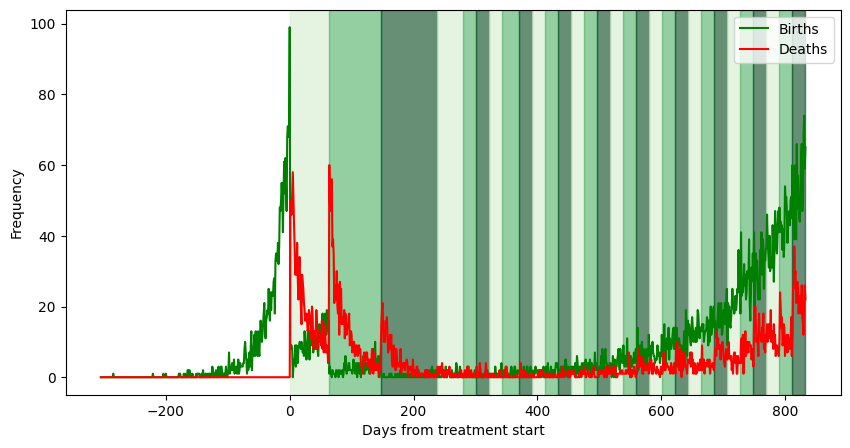

In [5]:
birth_death_counts = pd.read_csv("logs/birth_death_counts.csv").assign(
    days_from_detection=lambda df: (
        df["timestep"] - time_reached_detection - detection_treatment_delay
    )
)
# plot births and deaths over time on same plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

birth_death_counts.plot(
    x="days_from_detection",
    y=["birth_count", "death_count"],
    ax=ax,
    color=["green", "red"],
    legend=False,
)
ax.set_ylabel("Frequency")
ax.legend(["Births", "Deaths"])

# colour the background to indicate treatment
treatment_cycle_lower_x = 0
ylim = ax.get_ylim()
for i, cycle_times_row in cycle_times.iterrows():
    treatment_cycle_upper_x = (
        treatment_cycle_lower_x
        + cycle_times_row["timesteps_to_detection"]
        + tumour_measurement_delay
    )
    ax.fill_betweenx(
        ylim,
        treatment_cycle_lower_x,
        treatment_cycle_upper_x,
        alpha=0.6,
        color=treatment_colours[cycle_times_row["treatment"]],
    )
    treatment_cycle_lower_x = treatment_cycle_upper_x
ax.set_ylim(ylim)
ax.set_xlabel("Days from treatment start")
fig.savefig("plots/birth_death_counts.png", dpi=300)

In [6]:
cell_phenotypes = pd.read_csv("logs/cell_phenotypes.csv")
cell_phenotypes

,timestep,agent_id,n_cells,susceptible,R1,R2,R3
0,1,0,1,2.238848e-01,2.538030e-01,2.945253e-01,0.227787
1,2,0,1,2.240838e-01,2.537874e-01,2.944088e-01,0.227720
2,3,0,1,2.242831e-01,2.537716e-01,2.942922e-01,0.227653
3,4,0,1,2.244826e-01,2.537558e-01,2.941755e-01,0.227586
4,5,0,1,2.246823e-01,2.537399e-01,2.940587e-01,0.227519
...,...,...,...,...,...,...,...
195614,1139,3898,1,1.874862e-10,9.999793e-01,1.659970e-16,0.000021
195615,1139,3899,1,1.387170e-17,1.158830e-06,9.747353e-04,0.999024
195616,1139,3900,1,6.153626e-11,1.018269e-08,8.734606e-09,1.000000
195617,1139,3901,1,9.936842e-01,6.314184e-03,2.943765e-11,0.000002


MovieWriter imagemagick unavailable; using Pillow instead.


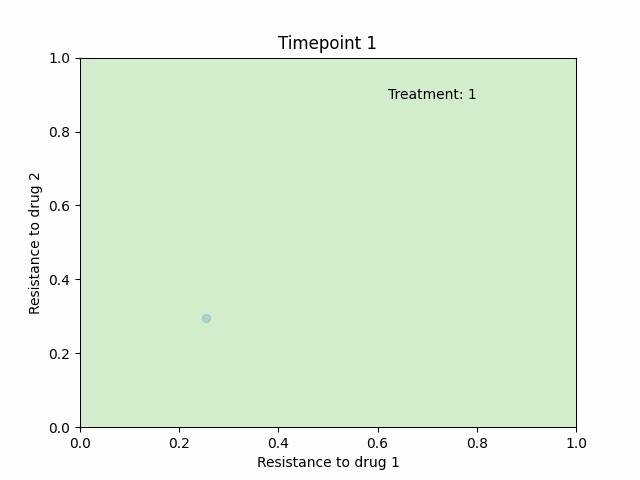

In [7]:
# animated scatter plot of resistant_0 against resistant_1 at each timepoint
import matplotlib.animation as animation
import matplotlib.colors as mcolors

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


cycle_start_times = (
    cycle_times["timesteps_to_detection"].cumsum()
    + cycle_times.index * tumour_measurement_delay
    + tumour_measurement_delay
    + time_reached_detection
    + detection_treatment_delay
)


treatments_by_timepoint = [
    (
        None
        if timestep < time_reached_detection + detection_treatment_delay
        # else 1 + ((timestep - time_reached_detection) // n_timesteps_treatment) % 3
        else 1 + (cycle_times[cycle_start_times <= timestep]["treatment"].iloc[-1])
    )
    for timestep in cell_phenotypes["timestep"].unique()
    if cycle_start_times[cycle_start_times <= timestep].any()
]
baseline_alpha = 0.2
max_n_cells = cell_phenotypes["n_cells"].max()
background_treatment_colours = plt.cm.Greens(
    np.linspace(0.2, 0.5, number_of_treatments)
)


def update(timepoint: int):
    ax.clear()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Timepoint {timepoint}")
    ax.scatter(
        cell_phenotypes[cell_phenotypes["timestep"] == timepoint]["R1"],
        cell_phenotypes[cell_phenotypes["timestep"] == timepoint]["R2"],
        alpha=(
            baseline_alpha
            + cell_phenotypes[cell_phenotypes["timestep"] == timepoint]["n_cells"]
            / max_n_cells
            * (1 - baseline_alpha)
        ),
    )
    ax.set_xlabel("Resistance to drug 1")
    ax.set_ylabel("Resistance to drug 2")
    ax.text(
        0.8,
        0.9,
        f"Treatment: {treatments_by_timepoint[timepoint]}",
        ha="right",
        va="center",
    )
    # set background colour to treatment colour
    if treatments_by_timepoint[timepoint] is not None:
        ax.set_facecolor(
            background_treatment_colours[treatments_by_timepoint[timepoint] - 1]
        )


animate_every_n_timesteps = 3
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(1, len(treatments_by_timepoint), animate_every_n_timesteps),
)
ani.save("tests/cell_phenotypes.gif", writer="imagemagick", fps=10)
plt.close()
# show the gif
from IPython.display import Image

Image("tests/cell_phenotypes.gif")

new version: proper clinical

* detected when it reaches a certain size; treatment 1 starts 10 timesteps later
* measure cell count periodically; switch treatment cyclically when it first moves upwards (or is within some epsilon, to represent nadir?)
* actually apply treatment-switch 7 timesteps later


Run this beauty overnight...

Extension tomorrow: switch from measuring cell count perfectly to measuring ctDNA (will need to fix the death for this...) and use ctDNA modelling team's best guess algorithm for when to switch.

In [8]:
# def map_to_barycentric(s:float,r1:float,r2:float,r3:float):